# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")

Local environment
Added the following directory to the PYTHONPATH: /home/jdowling/Projects/mlfs-book


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs import config
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 10, 6, 34, 21, 61904)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-01-10 06:34:21,087 INFO: Initializing external client
2025-01-10 06:34:21,088 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-10 06:34:22,558 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.7873287E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

/arrow/cpp/src/arrow/status.cc:137: DoAction result was not fully consumed: Cancelled: Flight cancelled call, with message: CANCELLED. Detail: Cancelled


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-01-13 00:00:00+00:00,3.15,0.2,25.068514,234.940491,stockholm
1,2025-01-11 00:00:00+00:00,-2.10,0.0,26.678890,3.093998,stockholm
2,2025-01-18 00:00:00+00:00,2.85,0.0,10.495713,239.036301,stockholm
3,2025-01-15 00:00:00+00:00,2.65,0.0,14.777550,235.922760,stockholm
4,2025-01-17 00:00:00+00:00,3.55,0.0,10.308831,282.094727,stockholm
5,2025-01-16 00:00:00+00:00,4.95,0.0,12.904882,292.988739,stockholm
6,2025-01-12 00:00:00+00:00,-7.45,0.0,10.315115,299.248718,stockholm
7,2025-01-14 00:00:00+00:00,2.55,0.0,10.028439,291.037567,stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-01-13 00:00:00+00:00,3.15,0.2,25.068514,234.940491,stockholm,26.384317
1,2025-01-11 00:00:00+00:00,-2.10,0.0,26.678890,3.093998,stockholm,11.998234
2,2025-01-18 00:00:00+00:00,2.85,0.0,10.495713,239.036301,stockholm,25.510099
3,2025-01-15 00:00:00+00:00,2.65,0.0,14.777550,235.922760,stockholm,31.598606
4,2025-01-17 00:00:00+00:00,3.55,0.0,10.308831,282.094727,stockholm,29.087725
5,2025-01-16 00:00:00+00:00,4.95,0.0,12.904882,292.988739,stockholm,19.915096
6,2025-01-12 00:00:00+00:00,-7.45,0.0,10.315115,299.248718,stockholm,55.311707
7,2025-01-14 00:00:00+00:00,2.55,0.0,10.028439,291.037567,stockholm,30.327738


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         8 non-null      datetime64[ns, Etc/UTC]
 1   temperature_2m_mean          8 non-null      float32                
 2   precipitation_sum            8 non-null      float32                
 3   wind_speed_10m_max           8 non-null      float32                
 4   wind_direction_10m_dominant  8 non-null      float32                
 5   city                         8 non-null      object                 
 6   predicted_pm25               8 non-null      float32                
dtypes: datetime64[ns, Etc/UTC](1), float32(5), object(1)
memory usage: 416.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
1,2025-01-11 00:00:00+00:00,-2.10,0.0,26.678890,3.093998,stockholm,11.998234,hornsgatan-108,sweden,2
6,2025-01-12 00:00:00+00:00,-7.45,0.0,10.315115,299.248718,stockholm,55.311707,hornsgatan-108,sweden,7
0,2025-01-13 00:00:00+00:00,3.15,0.2,25.068514,234.940491,stockholm,26.384317,hornsgatan-108,sweden,1
7,2025-01-14 00:00:00+00:00,2.55,0.0,10.028439,291.037567,stockholm,30.327738,hornsgatan-108,sweden,8
3,2025-01-15 00:00:00+00:00,2.65,0.0,14.777550,235.922760,stockholm,31.598606,hornsgatan-108,sweden,4
5,2025-01-16 00:00:00+00:00,4.95,0.0,12.904882,292.988739,stockholm,19.915096,hornsgatan-108,sweden,6
4,2025-01-17 00:00:00+00:00,3.55,0.0,10.308831,282.094727,stockholm,29.087725,hornsgatan-108,sweden,5
2,2025-01-18 00:00:00+00:00,2.85,0.0,10.495713,239.036301,stockholm,25.510099,hornsgatan-108,sweden,3


In [13]:
fv.enable_logging()

In [ ]:
# untransformed_features = batch_data.drop(columns=["predicted_pm25"])
# predictions = batch_data[["predicted_pm25"]]
# predictions["pm25"]=0.0
# fv.log(untransformed_features=untransformed_features, predictions=predictions, model=retrieved_model)

2025-01-10 06:37:42,099 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-01-10 06:37:42,119 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Uploading Dataframe: 100.00% |██████████| Rows 8/8 | Elapsed Time: 00:01 | Remaining Time: 00:00


[(Job('air_quality_fv_1_logging_untransformed_1_offline_fg_materialization', 'SPARK'),
  None)]

In [ ]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 13 to 11
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         18 non-null     datetime64[ns, Etc/UTC]
 1   temperature_2m_mean          18 non-null     float32                
 2   precipitation_sum            18 non-null     float32                
 3   wind_speed_10m_max           18 non-null     float32                
 4   wind_direction_10m_dominant  18 non-null     float32                
 5   city                         18 non-null     object                 
 6   predicted_pm25               18 non-null     float32                
 7   street                       18 non-null     object                 
 8   country                      18 non-null     object                 
 9   days_before_forecast_day     18 non-null     int64                  
dtypes: datet

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-01-09 20:17:45,975 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



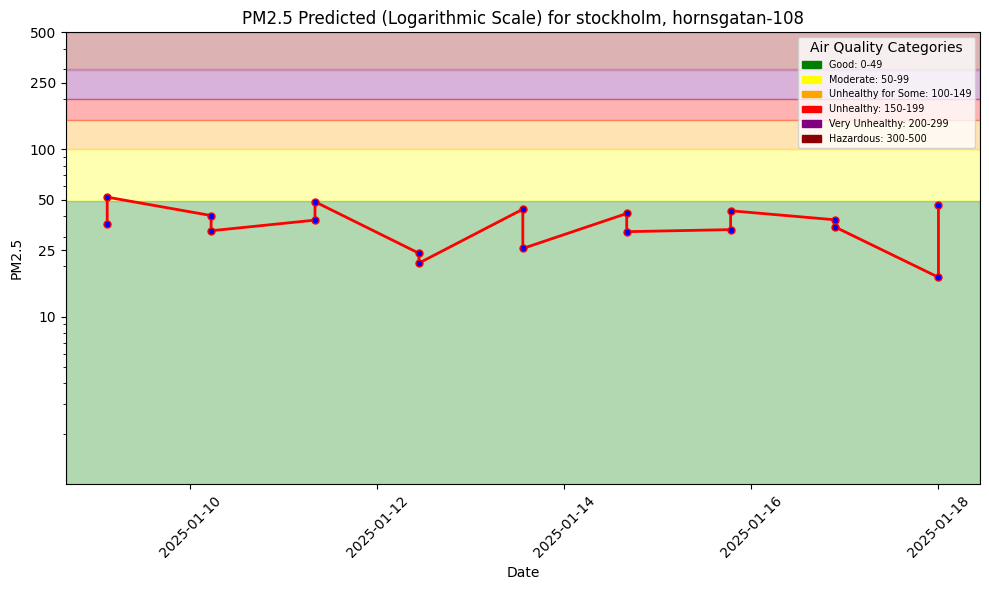

In [ ]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [ ]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, wait=True)

2025-01-09 20:17:46,844 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Uploading Dataframe: 100.00% |███████████████████████████████████████████████████████████████████████████████████████████| Rows 18/18 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/398/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-01-09 20:18:01,372 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-09 20:18:04,534 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-09 20:19:52,261 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-09 20:19:52,406 INFO: Waiting for log aggregation to finish.
2025-01-09 20:20:14,201 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [ ]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-01-15 00:00:00+00:00,10.05,0.0,8.891343,211.759430,ireland,32.225868,lucan--co.-dublin,ireland,1
1,2025-01-09 00:00:00+00:00,1.30,0.0,12.620554,273.270416,ireland,45.490944,lucan--co.-dublin,ireland,1
2,2025-01-15 00:00:00+00:00,10.05,0.0,8.891343,211.759430,stockholm,32.225868,hornsgatan-108,sweden,1


In [ ]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


,date,pm25,country,city,street,url
0,2024-05-31 00:00:00+00:00,28.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
1,2024-07-08 00:00:00+00:00,12.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
2,2024-07-16 00:00:00+00:00,30.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
3,2023-12-10 00:00:00+00:00,32.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
4,2023-07-10 00:00:00+00:00,15.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
...,...,...,...,...,...,...
1213,2023-07-18 00:00:00+00:00,13.0,sweden,stockholm,hornsgatan-108,https://api.waqi.info/feed/@10009
1214,2024-05-21 00:00:00+00:00,55.0,sweden,stockholm,hornsgatan-108,https://api.waqi.info/feed/@10009
1215,2023-09-09 00:00:00+00:00,53.0,sweden,stockholm,hornsgatan-108,https://api.waqi.info/feed/@10009
1216,2024-04-27 00:00:00+00:00,25.0,sweden,stockholm,hornsgatan-108,https://api.waqi.info/feed/@10009


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2025-01-09 00:00:00+00:00,45.490944,86.0
1,2025-01-09 00:00:00+00:00,45.490944,16.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

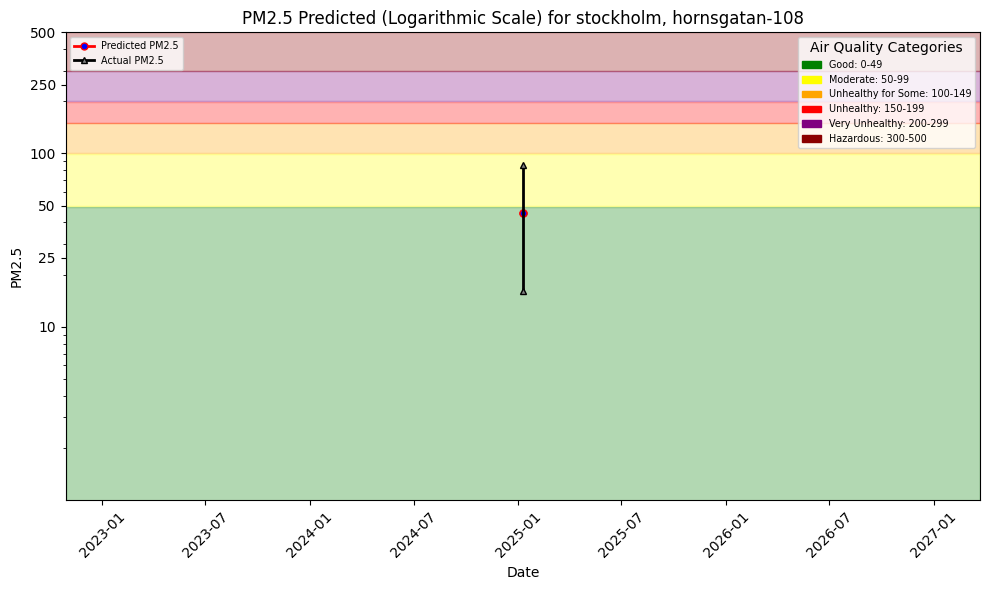

In [ ]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading: 0.000%|          | 0/51673 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/44131 elapsed<00:00 remaining<?

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/398/settings/fb/path/Resources/airquality


---